In [1]:
#Import libraries for simulation
import tensorflow as tf
assert tf.__version__.startswith('2')
import numpy as np
import time

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [2]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
    """Display an array as a picture."""
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    clear_output(wait = True)
    display(Image(data=f.getvalue()))

In [3]:
@tf.function
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    return tf.constant(a, dtype=1)

@tf.function
def simple_conv(x, k):
    """A simplified 2D convolution operation"""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(input=x, filter=k, strides=[1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]

In [4]:
@tf.function
def laplace_iso(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0.25, 0.5, 0.25],
                           [0.5, -3., 0.5],
                           [0.25, 0.5, 0.25]])
    return simple_conv(x, laplace_k)

@tf.function
def laplace_simple(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0., 1., 0.],
                           [1., -4., 1.],
                           [0., 1., 0.]])
    return simple_conv(x, laplace_k)

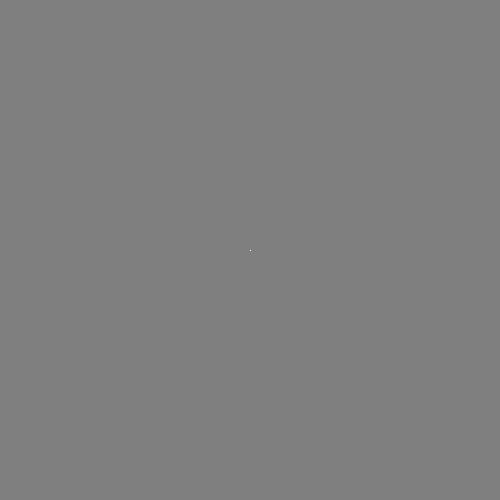

In [5]:
N = 500

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

u_init[N//2,N//2] = 10.

DisplayArray(u_init, rng=[-0.1, 0.1])

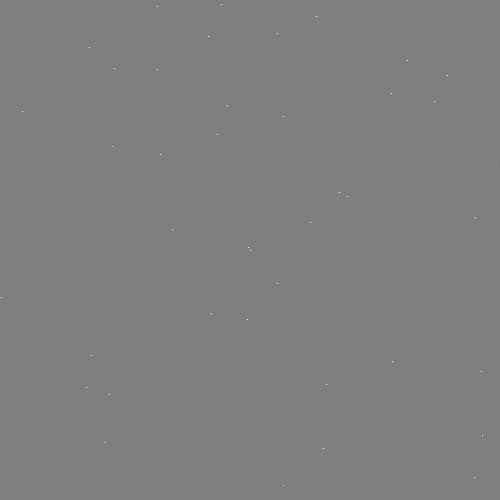

In [6]:
# more fun initial condition
for n in range(40):
    a,b = np.random.randint(0, N, 2)
    u_init[a,b] = np.random.uniform()
    
DisplayArray(u_init, rng=[-0.1, 0.1])

In [7]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
# c -- wave speed 
eps = 0.03
damping = 0.04
c = 3.

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

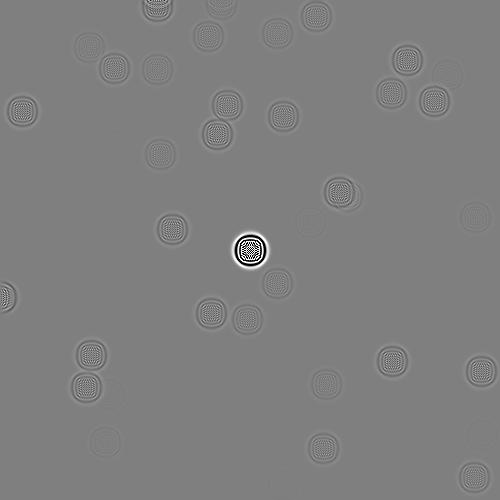

time it took is  53.45291304588318


In [9]:
# Run 1000 steps of PDE
start = time.time()
for i in range(300):
    # Step simulation
    # Discretized PDE update rules
    U = U + eps * Ut
    Ut = Ut + eps * (laplace_simple(U) - damping * Ut)
end = time.time() - start

# Show final image
DisplayArray(U.numpy(), rng=[-0.1, 0.1])
print("time it took is ", end)